Download housing.tgz and Decompress to Extract the CSV file

In [ ]:
#import os
#import tarfile
#from six.moves import urllib
#
#DOWNLOAD_ROOT = 'https://raw.githubusercontent.com/ageron/handson-ml/master/'
#HOUSING_PATH = 'datasets/housing'
#HOUSING_URL = DOWNLOAD_ROOT + HOUSING_PATH + '/housing.tgz'
#
#def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
#  if not os.path.isdir(housing_path):
#    os.makedirs(housing_path)
#  tgz_path = os.path.join(housing_path, 'housing.tgz')
#  urllib.request.urlretrieve(housing_url, tgz_path)
#  housing_tgz = tarfile.open(tgz_path)
#  housing_tgz.extractall(path=housing_path)
#  housing_tgz.close()

In [ ]:
import os

Load the Data with Pandas

In [ ]:
import pandas as pd
HOUSING_PATH = '/content/drive/MyDrive/Python/Projects/Hands-On Machine Learning with Scikit-Learn, Keras, and Tensorflow: Concepts, Tools, and Techniques to Build Intelligent Systems/Chapter 2/datasets/housing'
def load_housing_data(housing_path=HOUSING_PATH):
  csv_path = os.path.join(housing_path, 'housing.csv')
  return pd.read_csv(csv_path)

There are 20,640 instances in the dataset

Notice that the total_bed_rooms attribute has only 20,433 non-null values, meaning that 207 districts are missing this feature


In [ ]:
housing = load_housing_data()
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


Notice that the total_bed_rooms attribute has only 20,433 non-null values, meaning that 207 districts are missing this feature

The values in that column were repetitive, which means that it is
probably a categorical attribute

You can find out what categories exist and how many districts belong to each category by using the method value_counts()


In [ ]:
housing['ocean_proximity'].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

Let’s look at the other fields. The method shows a summary of the describe() numerical attributes

Note that the null values are
ignored

The 25%, 50%, and 75% rows show the corresponding percentiles: a percentile indicates the value below which a given percentage of observations in a group of observations falls

For example, 25% of the districts have a lower than housing_median_age 18, while 50% are lower than 29 and 75% are lower than 37. These are often called the 25th percentile (or 1st quartile), the median, and the 75th percentile (or 3rd quartile).

In [ ]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


Another quick way to get a feel of the type of data you are dealing with is to plot a histogram for each numerical attribute

A histogram shows the number of instances (on the vertical axis) that have a given value range (on the horizontal axis).

you can call the method on the hist() whole dataset, and it will plot a histogram for each numerical attribute

For example, you can see that slightly over 800 districts have a equal to about $500,000 median_house_value

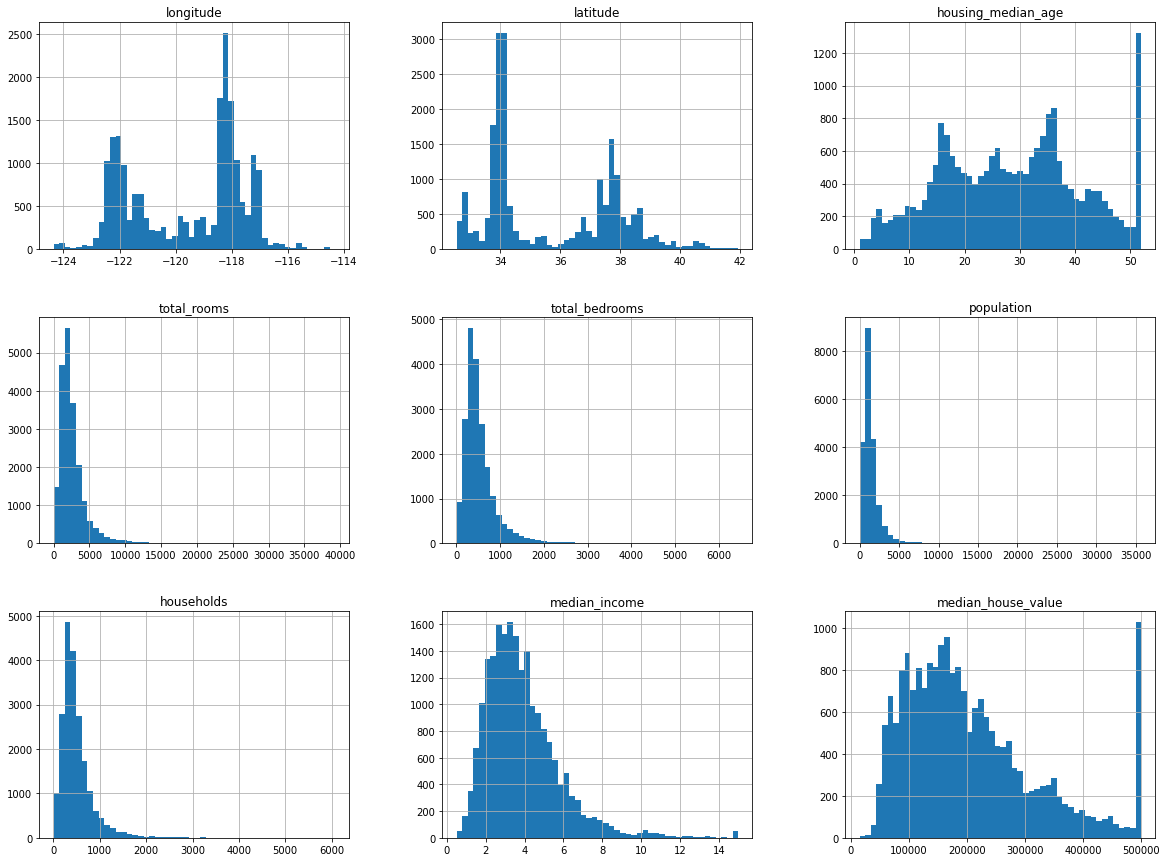

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
housing.hist(bins=50, figsize=(20,15))
plt.show()

Creating a test set is theoretically quite simple: just pick some instances randomly, typically 20% of the dataset, and set them aside


In [ ]:
import numpy as np

def split_train_test(data, test_ratio):
  shuffled_indices = np.random.permutation(len(data))
  test_set_size = int(len(data) * test_ratio)
  test_indices = shuffled_indices[:test_set_size]
  train_indices = shuffled_indices[test_set_size:]
  return data.iloc[train_indices], data.iloc[test_indices]

train_set, test_set = split_train_test(housing, 0.2)
print(str(len(train_set)) + ' train + ' + str(len(test_set)) + ' test')

16512 train + 4128 test


If you run the program again, it will generate a different test set! Over time, you (or your Machine Learning algorithms) will get to see the whole dataset, which is what you want to avoid

You could compute a hash of each instance’s identifier, keep only the last byte of the hash, and put the instance in the test set if this value is lower or equal to 51 (~20% of 256). 

This ensures that the test set will remain consistent across multiple runs, even if you refresh the dataset. The new test set will contain 20% of the new instances, but it will not contain any instance that was previously in the training set. Here is a possible implementation

In [ ]:
import hashlib

def test_set_check(identifier, test_ratio, hash):
  return hash(np.int64(identifier)).digest()[-1] < 256 * test_ratio

def split_train_test_by_id(data, test_ratio, id_column, hash=hashlib.md5):
  ids = data[id_column]
  in_test_set = ids.apply(lambda id_: test_set_check(id_, test_ratio, hash))
  return data.loc[~in_test_set], data.loc[in_test_set]

Unfortunately, the housing dataset does not have an identifier column. The simplest solution is to use the row index as the ID:

In [ ]:
housing_with_id = housing.reset_index()
train_set, test_set = split_train_test_by_id(housing_with_id, 0.2, 'index')

If you use the row index as a unique identifier, you need to make sure that new data gets appended to the end of the dataset, and no row ever gets deleted. If this is not possible, then you can try to use the most stable features to build a unique identifier. For example, a district’s latitude and longitude are guaranteed to be stable for a few million years, so you could combine them into an ID like so:

In [ ]:
housing_with_id['id'] = housing['longitude'] * 1000 + housing['latitude']
train_set, test_set = split_train_test_by_id(housing_with_id, 0.2, 'id')

Scikit-Learn provides a few functions to split datasets into multiple subsets in various ways. The simplest function is train_test_split, which does pretty much the same thing as the function split_train_test defined earlier, with a couple of additional features. First there is a random_state parameter that allows you to set the random generator seed as explained previously, and second you can pass it multiple datasets with an identical number of rows, and it will split them on the same indices

In [ ]:
from sklearn.model_selection import train_test_split
train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

So far we have considered purely random sampling methods. This is generally fine if your dataset is large enough (especially relative to the number of attributes), but if it is not, you run the risk of introducing a significant sampling bias. When a survey company decides to call 1,000 people to ask them a few questions, they don’t just pick 1,000 people randomly in a phone booth. They try to ensure that these 1,000 people are representative of the whole population. For example, the US population is composed of 51.3% female and 48.7% male, so a well-conducted survey in the US would try to maintain this ratio in the sample: 513 female and 487 male. This is called stratified sampling: the population is divided into homogeneous subgroups called strata, and the right number of instances is sampled from each stratum to guarantee that the test set is representative of the overall population. If they used purely random sampling, there would be about 12% chance of sampling a skewed test set with either less than 49% female or more than 54% female. Either way, the survey results would be significantly biased.

You may want to ensure that the test set is representative of the various categories of incomes in the whole dataset. Since the median income is a continuous numerical attribute, you first need to create an income category attribute. Let’s look at the median income histogram more closely.
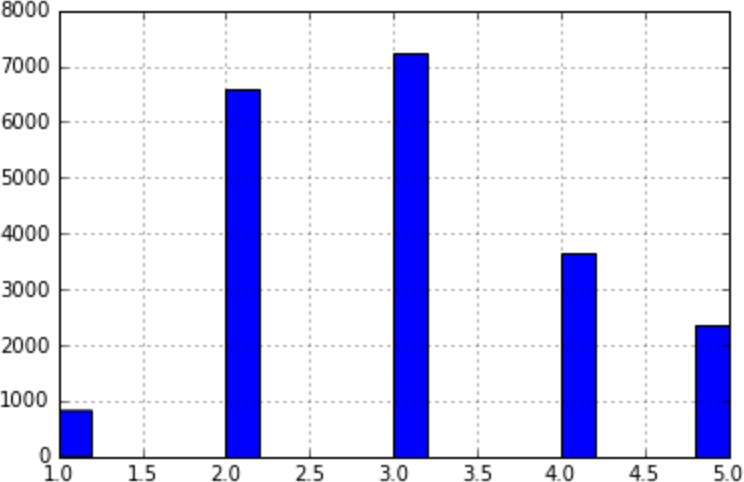

Most median income values are clustered around 2–5 (tens of thousands of dollars), but some median incomes go far beyond 6. It is important to have a sufficient number of instances in your dataset for each stratum, or else the estimate of the stratum’s importance may be biased. This means that you should not have too many strata, and each stratum should be large enough.


The following code creates an income category attribute by dividing the median income by 1.5 (to limit the number of income cate gories), and rounding up using (to have discrete categories), and then merging ceil all the categories greater than 5 into category 5:

In [ ]:
housing['income_cat'] = np.ceil(housing['median_income'] / 1.5)
housing['income_cat'].where(housing['income_cat'] < 5, 5.0, inplace=True)

Now you are ready to do stratified sampling based on the income category. For this you can use Scikit-Learn’s StratifiedShuffleSplit class:

In [ ]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(housing, housing['income_cat']):
  strat_train_set = housing.loc[train_index]
  strat_test_set = housing.loc[test_index]

Let’s see if this worked as expected. You can start by looking at the income category proportions in the full housing dataset

In [ ]:
housing['income_cat'].value_counts() / len(housing)

3.0    7236
2.0    6581
4.0    3639
5.0    2362
1.0     822
Name: income_cat, dtype: int64

With similar code you can measure the income category proportions in the test set